In [1]:
# 2024 fabio-affaticati

import pandas as pd
import numpy as np
import os
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from src.utils import plotting
from src.utils import tools

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri


from skbio.diversity import alpha_diversity
from statsmodels.stats.multitest import multipletests
from scipy.stats import pearsonr, spearmanr, mannwhitneyu, ttest_ind

In [2]:
FONT = 'JetBrains Mono'
FONTSNS =  'DejaVu Sans'

In [3]:
# define macros for directories

DATADIR = os.path.join(pathlib.Path().absolute(), 'data/')
RESULTSDIR = os.path.join(pathlib.Path().absolute(), 'results/')
PROCESSEDDIR = os.path.join(RESULTSDIR, 'processed_data/')
PLOTSDIR = os.path.join(pathlib.Path().absolute(), RESULTSDIR+'plots/')
MODELSDIR = os.path.join(RESULTSDIR, 'models/')

In [4]:
# create directories if they do not exist

for directory in [DATADIR, RESULTSDIR, PROCESSEDDIR, PLOTSDIR, MODELSDIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)

## Load metadata and read files

In [5]:
# Import metadata and apply transformations
metadata = (
    pd.read_excel(DATADIR + 'metadata.xlsx')
    .rename(columns={'SAMPLE_ID': 'sample_id'})
    .assign(
        sample_id=lambda df: df['sample_id'].astype(str),
        AB_TITER=lambda df: df['AB_TITER']
        .astype(str)
        .str.replace('>400', '400', regex=False)
        .str.replace(',', '.', regex=False)
        .str.replace('<', '', regex=False)
        .str.replace('V2 ', '', regex=False)
        .astype(float)
    )
    .assign(
        TIMEPOINTS=lambda df: df['TIMEPOINTS']
            .astype(str)
            .str.replace('V1', 'V1 (50 days)', regex=False)
            .str.replace('V3', 'V3 (6 months)', regex=False)
    )
    .assign(
        CONDITION=lambda df: df['CONDITION']
            .astype(str)
            .str.replace('Healthy', 'Healthy controls', regex=False)
            .str.replace('Lymphomas', 'Lymphoma patients', regex=False)
    )
)

In [6]:
data = (
    pd.read_csv(PROCESSEDDIR + 'preprocessed_data.csv', index_col=0, low_memory=False)
    .assign(
        length=lambda df: df['junction_aa'].str.len(),
        clonotype=lambda df: df['v_call'] + '_' + df['junction_aa'] + '_' + df['j_call']
    )
    .groupby(['clonotype', 'sample_id', 'SAMPLE', 'TIMEPOINTS', 'CONDITION', 'TCR_Chain', 'v_call', 'j_call', 'junction_aa'], as_index=False)
    .agg({'cloneFraction': 'sum', 'cloneCount': 'sum'})
    .reset_index(drop=True)
    .query('not (v_call == "TRBV15" and j_call == "TRBJ2-2" and junction_aa == "CATSLANTGELFF" and SAMPLE == "s_9")')
    .assign(
        TIMEPOINTS=lambda df: df['TIMEPOINTS']
            .astype(str)
            .str.replace('V1', 'V1 (50 days)', regex=False)
            .str.replace('V3', 'V3 (6 months)', regex=False)
    )
    .assign(
        CONDITION=lambda df: df['CONDITION']
            .astype(str)
            .str.replace('Healthy', 'Healthy controls', regex=False)
            .str.replace('Lymphomas', 'Lymphoma patients', regex=False)
    )
)

data['clonotype'].nunique()

5294164

In [7]:
data

,clonotype,sample_id,SAMPLE,TIMEPOINTS,CONDITION,TCR_Chain,v_call,j_call,junction_aa,cloneFraction,cloneCount
0,TRAV1-1_CAAAAGGSYIPTF_TRAJ6,13L,s_12,baseline,Lymphoma patients,TRA,TRAV1-1,TRAJ6,CAAAAGGSYIPTF,4.712700e-07,1.0
1,TRAV1-1_CAAAAGNKLTF_TRAJ17,A8,s_1,V3 (6 months),Healthy controls,TRA,TRAV1-1,TRAJ17,CAAAAGNKLTF,3.692506e-07,1.0
2,TRAV1-1_CAAAAPGGYQKVTF_TRAJ13,39670,s_7,baseline,Healthy controls,TRA,TRAV1-1,TRAJ13,CAAAAPGGYQKVTF,4.429688e-06,13.0
3,TRAV1-1_CAAAAVSKSTF_TRAJ27,20L,s_14,V1 (50 days),Lymphoma patients,TRA,TRAV1-1,TRAJ27,CAAAAVSKSTF,2.009788e-06,7.0
4,TRAV1-1_CAAACQAGTALIF_TRAJ15,A12,s_5,V3 (6 months),Healthy controls,TRA,TRAV1-1,TRAJ15,CAAACQAGTALIF,7.021049e-07,2.0
...,...,...,...,...,...,...,...,...,...,...,...
7913700,TRGV9_CVLWVPALF_TRGJ1,7L,s_10,baseline,Lymphoma patients,TRG,TRGV9,TRGJ1,CVLWVPALF,1.873815e-07,1.0
7913701,TRGV9_CVLWVYYYKKLF_TRGJ1,A2,s_2,V1 (50 days),Healthy controls,TRG,TRGV9,TRGJ1,CVLWVYYYKKLF,9.051215e-07,1.0
7913702,TRGV9_CVPCRGKLF_TRGJ1,A10,s_3,V3 (6 months),Healthy controls,TRG,TRGV9,TRGJ1,CVPCRGKLF,2.963851e-07,1.0
7913703,TRGV9_CVSYKKLF_TRGJ1,B2,s_7,V3 (6 months),Healthy controls,TRG,TRGV9,TRGJ1,CVSYKKLF,3.550874e-07,1.0


## Load DETECT predictions

In [8]:
DETECT_predictions = pd.read_csv(PROCESSEDDIR + 'DETECT_predictions.tsv', sep = '\t', low_memory=False)

# filter only SARS-CoV-2 Spike protein, we could choose a higher score threshold here to further remove false positives
DETECT_predictions = DETECT_predictions.query('Score >= 0.2 and Antigen == "Spike/surface glycoprotein (S)" and Species == "SARS-CoV-2"')

DETECT_predictions = (
    DETECT_predictions
    .assign(clonotype=lambda df: df['v_call'] + '_' + df['junction_aa'] + '_' + df['j_call'])
    .drop_duplicates(subset=['clonotype'])
    .reset_index(drop=True)
)

In [9]:
DETECT_predictions.head()

,junction_aa,v_call,j_call,Epitope,Score,Reference TCRs,Antigen,Species,clonotype
0,CVVNNQDDMRF,TRAV12-1,TRAJ43,YLQPRTFLL,0.855679,"[('CVVNNQDDMRF', '10.1016/j.immuni.2020.11.004')]",Spike/surface glycoprotein (S),SARS-CoV-2,TRAV12-1_CVVNNQDDMRF_TRAJ43
1,CVVNDADKLIF,TRAV12-1,TRAJ34,YLQPRTFLL,0.854991,"[('CVVNDADKLIF', '10.1016/j.cell.2022.07.002')]",Spike/surface glycoprotein (S),SARS-CoV-2,TRAV12-1_CVVNDADKLIF_TRAJ34
2,CVVNNLDDMRF,TRAV12-1,TRAJ43,YLQPRTFLL,0.840085,"[('CVVNNLDDMRF', '10.1016/j.immuni.2020.11.004')]",Spike/surface glycoprotein (S),SARS-CoV-2,TRAV12-1_CVVNNLDDMRF_TRAJ43
3,CVVNTLDDMRF,TRAV12-1,TRAJ43,YLQPRTFLL,0.812081,"[('CVVNTLDDMRF', '10.1016/j.immuni.2020.11.004')]",Spike/surface glycoprotein (S),SARS-CoV-2,TRAV12-1_CVVNTLDDMRF_TRAJ43
4,CVVNRRDDMRF,TRAV12-1,TRAJ43,YLQPRTFLL,0.770238,"[('CVVNRRDDMRF', '10.1016/j.immuni.2020.11.004...",Spike/surface glycoprotein (S),SARS-CoV-2,TRAV12-1_CVVNRRDDMRF_TRAJ43


## Unique clonotypes calculation

In [ ]:
uniques = (
    data.query('TCR_Chain in ["TRA", "TRB"]')
    .groupby(['sample_id', 'TCR_Chain'])['clonotype']
    .nunique()
    .reset_index(name='countUniqueCDR3')
    .merge(metadata, on='sample_id', how='left')
)

# group by sample_id and sum cloneCount
library_size = data.groupby(['sample_id','TCR_Chain']).agg({'cloneCount': 'sum'}).reset_index()

uniques = (
    uniques.merge(
        library_size,
        on=['sample_id', 'TCR_Chain'],
        how='left'
    )
    .assign(normalizedUniqueCDR3=lambda df: df['countUniqueCDR3'] / df['cloneCount'])
)

## Proportion of TCR sequences that recognize COVID-19 spike protein


In [ ]:
uniques_covid = pd.DataFrame({'countUniqueClonotypes': data \
                .groupby(['sample_id'])['clonotype'].nunique()}).reset_index()
uniques_covid = pd.merge(uniques_covid, metadata, on = 'sample_id', how='left')

covid_data = ( pd.merge(data[['clonotype','sample_id','SAMPLE','TIMEPOINTS','CONDITION']], \
                    DETECT_predictions.drop_duplicates(subset=['junction_aa','v_call', 'j_call']) \
                    [['clonotype','Score','Species']], \
                    on = ['clonotype'], how='left', indicator=True).query('_merge == "both"') )


# Add a column for detected clonotypes and aggregate by sample and condition
covid_data['NClonotypes_detected'] = 1
covid_data = ( covid_data
                    .groupby(['sample_id', 'SAMPLE', 'TIMEPOINTS', 'CONDITION'], as_index=False)
                    .agg(NClonotypes_detected=('NClonotypes_detected', 'sum')) )

covid_data = pd.merge(uniques_covid, covid_data)
covid_data['viral_ratio'] = covid_data['NClonotypes_detected']/covid_data['countUniqueClonotypes']
covid_data[['sample_id', 'countUniqueClonotypes', 'NClonotypes_detected', 'viral_ratio', 'CONDITION', 'TIMEPOINTS', 'SAMPLE']] \
    .to_csv(PROCESSEDDIR + 'covid_viral_data.csv')

In [ ]:
plotting.plot_covid_ratio(covid_data, PLOTSDIR)

## Proportion of TCR sequences that recognize different antigens in COVID-19 patients 

In [ ]:
uniques_other = pd.DataFrame({'countUniqueClonotypes': data \
                .groupby(['sample_id'])['clonotype'].nunique()}).reset_index()
uniques_other = pd.merge(uniques_other, metadata, on = 'sample_id', how='left')
uniques_other

,sample_id,countUniqueClonotypes,CODICE,CONDITION,TIMEPOINTS,SAMPLE,SEX,AGE,AB_TITER,Tipo di linfoma,Grado,Stadio,Data di morte,Data di progressione di malattia,Trattamento al momento della vaccinazione,Tipo di mutazione
0,10L,45495,676.0,Lymphoma patients,baseline,s_11,F,80,3.8,LNH,-,4,45108,44883,Non in trattamento alla vaccinazione prima rit...,-
1,11L,121149,NaN,Lymphoma patients,V1 (50 days),s_11,F,80,5.1,LNH,-,4,45108,44883,Non in trattamento alla vaccinazione prima rit...,-
2,12L,256083,NaN,Lymphoma patients,V3 (6 months),s_11,F,80,3.8,LNH,-,4,45108,44883,Non in trattamento alla vaccinazione prima rit...,-
3,13L,243979,674.0,Lymphoma patients,baseline,s_12,F,68,3.8,LNH,G3A,-,-,-,rituximab,Positivo il riarrangiamento con IgH
4,14L,477076,NaN,Lymphoma patients,V1 (50 days),s_12,F,68,3.8,LNH,G3A,-,-,-,rituximab,Positivo il riarrangiamento con IgH
5,15L,231744,NaN,Lymphoma patients,V3 (6 months),s_12,F,68,3.8,LNH,G3A,-,-,-,rituximab,Positivo il riarrangiamento con IgH
6,16L,19240,678.0,Lymphoma patients,baseline,s_13,F,55,3.8,LNH,-,-,-,-,R-bendamustin prima nel 2020,-
7,17L,34860,NaN,Lymphoma patients,V1 (50 days),s_13,F,55,3.8,LNH,-,-,-,-,R-bendamustin prima nel 2020,-
8,18L,25507,NaN,Lymphoma patients,V3 (6 months),s_13,F,55,3.8,LNH,-,-,-,-,R-bendamustin prima nel 2020,-
9,19L,11651,683.0,Lymphoma patients,baseline,s_14,F,75,3.8,LNH (DLBCL),-,4,-,-,R-COMP prima del vaccino,-


In [ ]:
DETECT_predictions_other_viruses = pd.read_csv(PROCESSEDDIR + 'DETECT_predictions.tsv', sep = '\t', low_memory=False)
# filter out SARS-CoV-2, we could choose a higher score threshold here to further remove false positives
DETECT_predictions_other_viruses = DETECT_predictions_other_viruses \
                                    .query('Score >= 0.2 and Species != "SARS-CoV-2" \
                                    and Species != "SARS-CoV-2,SARS-CoV"')

# Reset index and create a unique clonotype identifier
DETECT_predictions_other_viruses = (
    DETECT_predictions_other_viruses
    .assign(clonotype=lambda df: df['v_call'] + '_' + df['junction_aa'] + '_' + df['j_call'])
    .drop_duplicates(subset=['clonotype'])
    .reset_index(drop=True)
)

In [ ]:
# remove those rows that have Home sapiens in Species
DETECT_predictions_other_viruses = DETECT_predictions_other_viruses.query('Species != "SARS-CoV-2,SARS-CoV" \
                                and Species != "Homo sapiens" \
                                and Species != "Synthetic" \
                                and Species != "Hepatitis C virus,Synthetic" \
                                and Species != "Homo sapiens,Synthetic" \
                                and Species != "HTLV-1,Homo sapiens"')

In [ ]:
print(DETECT_predictions_other_viruses['Species'].unique())

['Human betaherpesvirus 5' 'HIV' 'Yellow fever virus'
 'Human gammaherpesvirus 4' 'Hepatitis C virus' 'HPV' 'HIV,HIV-1'
 'Influenza A virus' 'Mycobacterium' 'Influenza B virus'
 'Hepatitis B virus' 'Influenza A virus,Influenza B virus' 'Bacteria'
 'Triticum aestivum' 'Human mastadenovirus C' 'Dengue Virus 1' 'HTLV-1'
 'Chrysanthemum virus B' 'Human alphaherpesvirus 2' 'HIV-1,HIV'
 'Rotavirus' 'Plasmodium falciparum' 'Pseudomonas aeruginosa'
 'Dengue Virus 3,Dengue Virus 4' 'Human alphaherpesvirus 1']


In [ ]:
other_virus_data = ( pd.merge(data[['clonotype','sample_id','SAMPLE','TIMEPOINTS','CONDITION']], \
                    DETECT_predictions_other_viruses.drop_duplicates(subset=['junction_aa','v_call', 'j_call']) \
                    [['clonotype','Score','Species']], \
                    on = ['clonotype'], how='left', indicator=True).query('_merge == "both"') )


# Add a column for detected clonotypes and aggregate by sample and condition
other_virus_data['NClonotypes_detected'] = 1
other_virus_data = ( other_virus_data
                    .groupby(['sample_id', 'SAMPLE', 'TIMEPOINTS', 'CONDITION'], as_index=False)
                    .agg(NClonotypes_detected=('NClonotypes_detected', 'sum')) )

In [ ]:
other_virus_data = pd.merge(uniques_other, other_virus_data)
other_virus_data['viral_ratio'] = other_virus_data['NClonotypes_detected']/other_virus_data['countUniqueClonotypes']
other_virus_data[['sample_id', 'countUniqueClonotypes', 'NClonotypes_detected', 'viral_ratio', 'CONDITION', 'TIMEPOINTS', 'SAMPLE']] \
    .to_csv(PROCESSEDDIR + 'other_viral_data.csv')

In [ ]:
plotting.plot_viral_ratio(other_virus_data, PLOTSDIR)

## HLA prediction data for HLA-Guessr (no need to execute if predictions already available)

In [ ]:
hla_data = data.copy()

selected = [
    "junction_aa",
    "v_call",
    "SAMPLE",   
    "TCR_Chain" 
]
renamed = [
    "cdr3aa",
    "v_gene",
    "Patient",
    "TCR_Chain"
]

hla_data = hla_data[selected].rename(columns=dict(zip(selected, renamed))).drop_duplicates()
hla_data_beta = hla_data.query('TCR_Chain == "TRB"').drop(columns=['TCR_Chain'])
hla_data_alpha = hla_data.query('TCR_Chain == "TRA"').drop(columns=['TCR_Chain'])

hla_data_alpha.to_csv('/Users/fabioaffaticati/Desktop/Work/HLA-guessr/alpha_chains/hla_data_alpha_lucia.tsv', sep='\t', index=False)
hla_data_beta.to_csv('/Users/fabioaffaticati/Desktop/Work/HLA-guessr/beta_chains/hla_data_beta_lucia.tsv', sep='\t', index=False)

## HLA prediction data for HLA3 (no need to execute if predictions already available)

In [14]:
hla3_data = data.copy()
hla3_data = hla3_data.query('TCR_Chain == "TRB"')

hla3_data = hla3_data.groupby(['clonotype', 'SAMPLE', 'v_call','j_call','junction_aa'], as_index=False) \
                            .agg({'cloneFraction': 'sum', 'cloneCount': 'sum'}) 
                            
hla3_data[['v_call', 'j_call']] += '*01'

selected = [
    "junction_aa",
    "v_call",
    "j_call",
    "SAMPLE",   
    "cloneCount",
    "cloneFraction"
]
renamed = [
    "cdr3_b_aa",
    "v_b_gene",
    "j_b_gene",
    "subject",
    "count",
    "productive_frequency"
]


hla3_data = hla3_data[selected].rename(columns=dict(zip(selected, renamed)))

for patient in hla3_data['subject'].unique():
    patient_data = hla3_data.query('subject == @patient')
    patient_data['sum_productive_templates_calc'] = patient_data['count'].sum()
    patient_data.to_csv( ( os.path.join("/Users/fabioaffaticati/Desktop/Work/HLA3/hla3-main/input_data/lucia_data/",
                                    patient+'.hla3_data.tsv') ), sep='\t', index=False)


/var/folders/br/mxlpyjk52nz_ksh4b5vpy4340000gn/T/ipykernel_31034/1173232041.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/br/mxlpyjk52nz_ksh4b5vpy4340000gn/T/ipykernel_31034/1173232041.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/br/mxlpyjk52nz_ksh4b5vpy4340000gn/T/ipykernel_31034/1173232041.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

## Load and combine HLA predictions

In [ ]:
hla3_predictions = pd.read_csv(PROCESSEDDIR + 'hla3_predictions.tsv', sep='\t')[['sample', 'hla_1', 'hla_2', 'locus']]
hla_guessr_predictions = pd.read_csv(PROCESSEDDIR + 'HLA-Guessr_predictions.tsv', sep='\t')[['Individual_ID', 'hla_1', 'hla_2', 'locus']]

renamed = [
    "sample",
    "guessr_hla_1",
    "guessr_hla_2",
    'locus'
]
hla_guessr_predictions.columns = renamed


In [ ]:
combined_predictions = pd.merge(hla3_predictions, hla_guessr_predictions,
                            on=['sample','locus'],how='outer')

# for each row, if there is a match between hla_1 and guessr_hla_1
# or guessr_hla_2 put the value in the column match
combined_predictions['match'] = np.nan
combined_predictions['match'] = combined_predictions.apply(
    lambda row: row['hla_1'] if row['hla_1'] in [row['guessr_hla_1'], row['guessr_hla_2']] else 
                (row['hla_2'] if row['hla_2'] in [row['guessr_hla_1'], row['guessr_hla_2']] else row['hla_1']), axis=1)


# save as excel file
combined_predictions.to_excel(PROCESSEDDIR + 'combined_hla_predictions.xlsx', index=False)
# save as csv
combined_predictions.to_csv(PROCESSEDDIR + 'combined_hla_predictions.csv')
combined_predictions.rename(columns={'sample': 'SAMPLE'}, inplace=True)

In [ ]:
# Count how many times hla_1 or hla_2 appear in guessr_hla_1 or guessr_hla_2 in total, in combined_predictions
def count_hla_matches(row):
    matches = 0
    guessr_hlas = [row['guessr_hla_1'], row['guessr_hla_2']]
    if row['hla_1'] in guessr_hlas:
        matches += 1
    elif row['hla_2'] in guessr_hlas:
        matches += 1
    return matches

matches = sum(combined_predictions.apply(count_hla_matches, axis=1))
concordance_ratio = matches / len(combined_predictions)
concordance_ratio = round(concordance_ratio, 4)

print(f'Concordance ratio: {concordance_ratio*100}% ({matches} matches out of {len(combined_predictions)} HLA predictions)')


Accordance ratio: 68.63% (35 matches out of 51 HLA predictions)


## CDR3 length distributions

In [ ]:
kolmogorov_data = (
    pd.merge(data, DETECT_predictions.drop_duplicates(subset=['junction_aa', 'v_call', 'j_call'])[['junction_aa', 'v_call', 'j_call']], 
             how='left', indicator=True)
    .query('_merge == "both"')
    .query('SAMPLE != "s_1" and SAMPLE != "s_10" and TCR_Chain == "TRB"')
    .assign(junction_aa=lambda df: df['clonotype'].str.split('_').str[1],
            CDR3_length=lambda df: df['junction_aa'].str.len())
    .drop_duplicates(subset=['SAMPLE', 'TIMEPOINTS', 'CONDITION', 'junction_aa', 'CDR3_length'])
    .reset_index(drop=True)
)


In [ ]:
plotting.plot_cdr3_length_distribution(kolmogorov_data,
                                       ['baseline', 'V1 (50 days)', 'V3 (6 months)'],
                                       PLOTSDIR)

baseline - KS test statistic: 0.017985067097164766, p-value: 0.9999996645501722
V1 (50 days) - KS test statistic: 0.02608275230291618, p-value: 0.9930944633812997
V3 (6 months) - KS test statistic: 0.03717666543180283, p-value: 0.5740014124009726


In [ ]:
plotting.plot_repertoire_sizes(uniques, 'before_resampling_', PLOTSDIR)

In [ ]:
tcra_size_resample = round(uniques.query('not(CONDITION == "Healthy controls" \
                                        and TIMEPOINTS == "V3 (6 months)") \
                                        and TCR_Chain == "TRA"')['countUniqueCDR3'].mean())
tcrb_size_resample = round(uniques.query('not(CONDITION == "Healthy controls" \
                                        and TIMEPOINTS == "V3 (6 months)") \
                                        and TCR_Chain == "TRB"')['countUniqueCDR3'].mean())

In [ ]:
tcrb_size_resample

59749

In [ ]:
# resample data to get a distribution of unique CDR3s
# the probability that a row will be selected is proportional to the cloneFraction
# the number of unique rows to select is equal to the a value given
def resample(data, size, random_state = 42):
    return data.sample(n=size, replace=False, weights=data['cloneFraction'], random_state=random_state)

## 1000 fold resampling

In [ ]:
def resampling_test(data, uniques):
    
    meanFractions = []

    for perm in tqdm(range(1000)):
        
        
        res = []
        
        for sample_id in uniques.query('CONDITION == "Healthy" and TIMEPOINTS == "V3"')['sample_id'].unique():
            
            resampled = resample(data.query('sample_id == @sample_id and TCR_Chain == "TRB"'), tcrb_size_resample, random_state = perm)
            
            res.append(resampled)
            
        res = pd.concat(res)
                
        res = pd.merge(res, DETECT_predictions.drop_duplicates(subset=['junction_aa','v_call', 'j_call'])
                    [['junction_aa','v_call', 'j_call']], how='left', indicator=True)

        res = res.query('_merge == "both"')
        
        res = res.groupby(
            ['sample_id', 'CONDITION', 'TIMEPOINTS', 'SAMPLE'], as_index=False).agg({'cloneFraction': 'sum'})

        meanFractions.append(np.mean(res['cloneFraction']))
        
    return meanFractions


In [ ]:
#meanFractions = resampling_test(data, uniques)

### Long code, save the results to not execute it every time
#meanFractions = resampling_test(data, uniques)
## save the mean fractions to a csv file
#df = pd.DataFrame([x.round(7) for x in meanFractions], columns=['Value']).value_counts().reset_index(name='Frequency')
#df.to_csv(PROCESSEDDIR + 'resampling_test.csv', index=False)

In [ ]:
resampling_test = pd.read_csv(PROCESSEDDIR + 'resampling_test.csv')
resampling_test.head()

,Value,Frequency
0,0.000153,17
1,0.000153,16
2,0.000155,15
3,0.000153,15
4,0.000153,14


In [ ]:
resampled_data = pd.DataFrame()
for sample_id in uniques.query('CONDITION == "Healthy controls" and TIMEPOINTS == "V3 (6 months)"')['sample_id'].unique():
    
    for chain in ['TRA', 'TRB']:
        
        if chain == 'TRA':
            resampled = resample(data.query('sample_id == @sample_id and TCR_Chain == @chain'), tcra_size_resample, random_state = 42)
        else:
            resampled = resample(data.query('sample_id == @sample_id and TCR_Chain == @chain'), tcrb_size_resample, random_state = 42)
            
        if resampled_data.empty:
            resampled_data = resampled
        else:
            resampled_data = pd.concat([resampled, resampled_data])

In [ ]:
selected_resampling_covid = resampled_data.query('TCR_Chain == "TRB"')
selected_resampling_covid = pd.merge(selected_resampling_covid, DETECT_predictions.drop_duplicates(subset=['junction_aa','v_call', 'j_call'])
                    [['junction_aa','v_call', 'j_call']], how='left', indicator=True)

selected_resampling_covid = selected_resampling_covid.query('_merge == "both"')
selected_resampling_covid = selected_resampling_covid.groupby(['sample_id', 'CONDITION', 'TIMEPOINTS', 'SAMPLE'],
                                                              as_index=False).agg({'cloneFraction': 'sum'})['cloneFraction'].mean()

In [ ]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
mean_clone_dist = ro.globalenv['mean_clone_dist']
mean_clone_dist(resampling_test, selected_resampling_covid.round(7), PLOTSDIR)

NameError: name 'resampling_test' is not defined

## From now on we will use the resampled data

In [ ]:
# select if the sample is not Healthy V3
resampling_data = data.query('not(CONDITION == "Healthy controls" and TIMEPOINTS == "V3 (6 months)")')
resampling_data = pd.concat([resampling_data, resampled_data])
resampling_data.reset_index(drop=True, inplace=True)

In [ ]:
uniques = pd.DataFrame({'countUniqueCDR3': resampling_data.query('TCR_Chain == "TRA" \
                        or TCR_Chain == "TRB"').groupby(['sample_id', 'TCR_Chain'])['clonotype'].nunique()}).reset_index()
uniques = pd.merge(uniques, metadata, on = 'sample_id', how='left')

# group by sample_id and sum cloneCount
library_size = data.groupby(['sample_id','TCR_Chain']).agg({'cloneCount': 'sum'}).reset_index()
uniques = pd.merge(uniques, library_size, on = ['sample_id', 'TCR_Chain'], how='left')
uniques['normalizedUniqueCDR3'] = uniques['countUniqueCDR3'] / uniques['cloneCount']

In [ ]:
plotting.plot_repertoire_sizes(uniques, 'after_resampling_', PLOTSDIR)

In [ ]:
resampling_data = resampling_data.query('TCR_Chain == "TRB"') ### Using only TRB

In [ ]:
# sum the cloneCount for each sample_id and recaluclate the cloneFraction for each clonotype
resampling_data['cloneFraction'] =  resampling_data['cloneCount'] / resampling_data.groupby('sample_id')['cloneCount'].transform('sum')

In [ ]:
data = resampling_data

## Sample 9 outlier clonotype (will be removed from the depth analysis)

In [ ]:
s_9_data = pd.merge(data, DETECT_predictions.drop_duplicates(subset=['junction_aa','v_call', 'j_call'])[['junction_aa','v_call', 'j_call']], how='left', indicator=True)
s_9_data = s_9_data.query('SAMPLE == "s_9" and _merge == "both"')
s_9_data.sort_values(by=['cloneFraction'], ascending=False, inplace=True)
s_9_data.head()

,clonotype,sample_id,SAMPLE,TIMEPOINTS,CONDITION,TCR_Chain,v_call,j_call,junction_aa,cloneFraction,cloneCount,_merge
2352129,TRBV7-3_CASSPPNTGELFF_TRBJ2-2,6L,s_9,V3 (6 months),Lymphoma patients,TRB,TRBV7-3,TRBJ2-2,CASSPPNTGELFF,0.000074,120.0,both
2187320,TRBV6-6_CASTQRNTGELFF_TRBJ2-2,5L,s_9,V1 (50 days),Lymphoma patients,TRB,TRBV6-6,TRBJ2-2,CASTQRNTGELFF,0.000051,82.0,both
2187319,TRBV6-6_CASTQRNTGELFF_TRBJ2-2,4L,s_9,baseline,Lymphoma patients,TRB,TRBV6-6,TRBJ2-2,CASTQRNTGELFF,0.000047,64.0,both
1786540,TRBV5-1_CASSPGQGGNTGELFF_TRBJ2-2,4L,s_9,baseline,Lymphoma patients,TRB,TRBV5-1,TRBJ2-2,CASSPGQGGNTGELFF,0.000044,60.0,both
2352128,TRBV7-3_CASSPPNTGELFF_TRBJ2-2,5L,s_9,V1 (50 days),Lymphoma patients,TRB,TRBV7-3,TRBJ2-2,CASSPPNTGELFF,0.000044,70.0,both


## Prepare data for breadth and depth analysis

In [38]:
# take only beta chains
#data = data.query('TCR_Chain == "TRB"')
#data.reset_index(drop=True, inplace=True)

# group rows that have the same sample_id and junction_aa
breadth_depth_grouped_data = data.groupby(['junction_aa', 'sample_id', 'SAMPLE',
                                    'TIMEPOINTS', 'CONDITION', 'TCR_Chain', 'j_call', 'v_call'],
                                     as_index=False).agg({'cloneFraction': 'sum', 'cloneCount': 'sum',})
                                    
breadth_depth_grouped_data.to_csv(PROCESSEDDIR + 'breadth-depth_grouped_data.csv', index=False)

In [39]:
breadth_depth_grouped_data

,junction_aa,sample_id,SAMPLE,TIMEPOINTS,CONDITION,TCR_Chain,j_call,v_call,cloneFraction,cloneCount
0,CAAAAANTGELFF,12L,s_11,V3 (6 months),Lymphoma patients,TRB,TRBJ2-2,TRBV19,5.669783e-06,5.0
1,CAAAADSTGELFF,13L,s_12,baseline,Lymphoma patients,TRB,TRBJ2-2,TRBV7-2,6.816521e-06,5.0
2,CAAAAFYGYTF,39465,s_4,baseline,Healthy controls,TRB,TRBJ1-2,TRBV19,1.027930e-06,2.0
3,CAAAAGLGLSTDTQYF,11L,s_11,V1 (50 days),Lymphoma patients,TRB,TRBJ2-3,TRBV2,4.779429e-06,4.0
4,CAAAAGPNSPLHF,20L,s_14,V1 (50 days),Lymphoma patients,TRB,TRBJ1-6,TRBV20-1,7.363900e-07,1.0
...,...,...,...,...,...,...,...,...,...,...
3047212,CYYEQYF,39670,s_7,baseline,Healthy controls,TRB,TRBJ2-7,TRBV11-3,4.575130e-05,56.0
3047213,CYYEQYF,A7,s_7,V1 (50 days),Healthy controls,TRB,TRBJ2-7,TRBV11-3,5.478867e-06,12.0
3047214,CYYEQYF,B2,s_7,V3 (6 months),Healthy controls,TRB,TRBJ2-7,TRBV11-3,7.955013e-05,58.0
3047215,CYYLGVGELFF,3L,s_8,V3 (6 months),Lymphoma patients,TRB,TRBJ2-2,TRBV28,4.455629e-06,5.0


## Clonal breadth

In [40]:
clonal_breadth_data = pd.read_csv(PROCESSEDDIR + 'breadth-depth_grouped_data.csv')

# Remove patients positive to SARS-CoV-2 at baseline
clonal_breadth_data = clonal_breadth_data.query('SAMPLE != "s_1" and SAMPLE != "s_10"')

clonal_breadth_data = pd.merge(clonal_breadth_data,
                        DETECT_predictions.drop_duplicates(subset=['junction_aa','v_call', 'j_call'])[['junction_aa','v_call', 'j_call']], how='left', indicator=True)

clonal_breadth_data = clonal_breadth_data.groupby(['sample_id', 'CONDITION', 'TIMEPOINTS', 'SAMPLE'], as_index=False).apply(lambda x: x['_merge'].value_counts())
clonal_breadth_data['total'] = clonal_breadth_data['left_only'] + clonal_breadth_data['both']
clonal_breadth_data['fraction_sequences'] = clonal_breadth_data['both']/clonal_breadth_data['total']

clonal_breadth_data = clonal_breadth_data.sort_values(by=['SAMPLE', 'TIMEPOINTS'], ascending=[True, False])

clonal_breadth_data.rename(columns={'fraction_sequences': 'Covid_clonal_breadth'}).reset_index(drop=True).to_csv(PROCESSEDDIR + 'share_clonal_breadth.csv', index=False)

/var/folders/br/mxlpyjk52nz_ksh4b5vpy4340000gn/T/ipykernel_92249/2267812464.py:9: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



### Clonal breadth correlation with AB titers

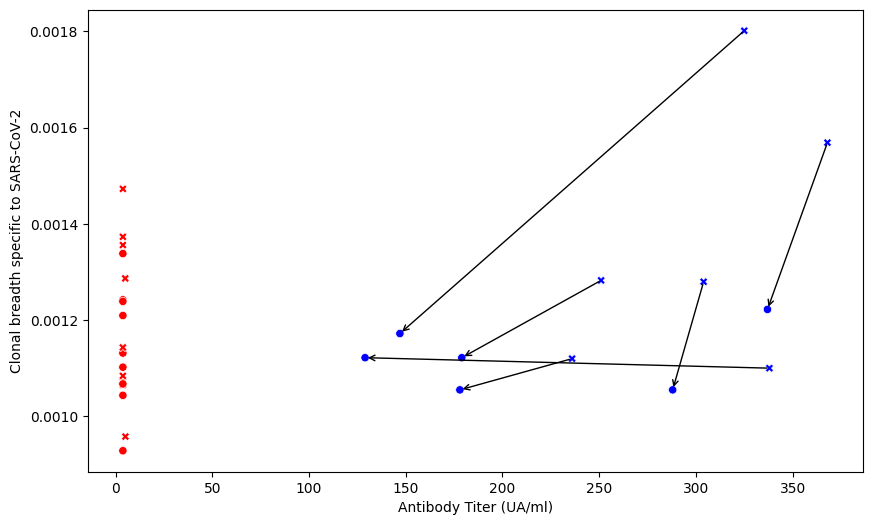

In [ ]:
sns.scatterplot(pd.merge(clonal_breadth_data, metadata, how='inner').query('TIMEPOINTS != "baseline"'),
                x='AB_TITER', y='fraction_sequences', hue='CONDITION', style='TIMEPOINTS',
                palette={'Lymphoma patients': 'red', 'Healthy controls': 'blue'})


# remove grid
plt.grid(False)
# change y axis title
plt.ylabel('Clonal breadth specific to SARS-CoV-2')
plt.xlabel('Antibody Titer (UA/ml)')

# link dots that have the same sample_id with an arrow
for sample in pd.merge(clonal_breadth_data, metadata, how='inner').query('TIMEPOINTS != "baseline" and CONDITION == "Healthy controls"')['SAMPLE'].unique():
    sample_data = pd.merge(clonal_breadth_data, metadata, how='inner').query('TIMEPOINTS != "baseline" and SAMPLE == @sample')
    
    # add arrow between the two points
    plt.annotate('', xy=(sample_data['AB_TITER'].values[0], sample_data['fraction_sequences'].values[0]),
                 xytext=(sample_data['AB_TITER'].values[1], sample_data['fraction_sequences'].values[1]),
                 arrowprops=dict(arrowstyle='->', color='black', lw=1))
    
# change dimensions
plt.gcf().set_size_inches(10, 6)

# hide legend
plt.legend().set_visible(False)
# save the plot at 600 dpi
plt.savefig(PLOTSDIR + 'clonal_breadth_ab_titers.png', dpi=600, bbox_inches='tight')

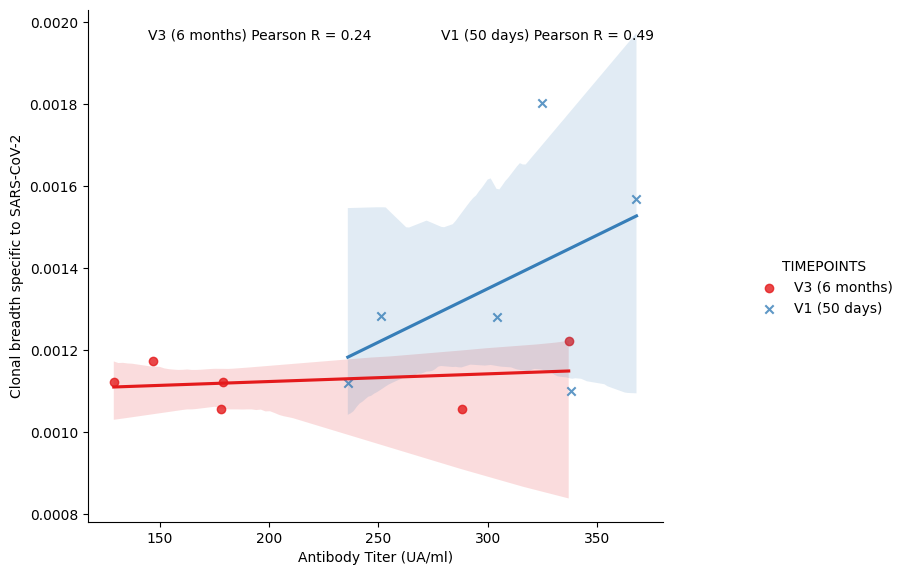

In [44]:
healthy_data = (pd.merge(clonal_breadth_data, metadata, how='inner')
                .query('TIMEPOINTS != "baseline" and CONDITION == "Healthy controls"'))


sns.lmplot(x="AB_TITER", y="fraction_sequences", hue="TIMEPOINTS", data=healthy_data, markers=["o", "x"], palette="Set1")
# change size of the plot
plt.gcf().set_size_inches(10, 6)
plt.ylabel('Clonal breadth specific to SARS-CoV-2')
plt.xlabel('Antibody Titer (UA/ml)')

# add R^2 value to the plot for each timepoint
for i,timepoint in enumerate(healthy_data['TIMEPOINTS'].unique()):
    timepoint_data = healthy_data.query('TIMEPOINTS == @timepoint')
    r, p = pearsonr(timepoint_data['AB_TITER'], timepoint_data['fraction_sequences'])
    plt.text(0.3+i*0.5, .95, f'{timepoint} Pearson R = {r:.2f}', ha='center', va='center', transform=plt.gca().transAxes)
    
    # save the plot at 600 dpi
plt.savefig(PLOTSDIR + 'clonal_breadth_ab_titers_correlation.png', dpi=600, bbox_inches='tight')

In [50]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
plot_scatteratio_breadth = ro.globalenv['plot_scatteratio_breadth']
plot_scatteratio_breadth(clonal_breadth_data[['fraction_sequences', 'CONDITION', 'TIMEPOINTS', 'SAMPLE']], PLOTSDIR)

R[write to console]: In aggiunta: 
R[write to console]: Messaggio di avvertimento:

R[write to console]: No shared levels found between `names(values)` of the manual scale and the
data's fill values. 

R[write to console]: Caricamento del pacchetto richiesto: tidyverse



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


R[write to console]: Caricamento del pacchetto richiesto: scales

R[write to console]: 
Caricamento pacchetto: ‘scales’


R[write to console]: Il seguente oggetto è mascherato da ‘package:purrr’:

    discard


R[write to console]: Il seguente oggetto è mascherato da ‘package:readr’:

    col_factor




Saving 7 x 7 in image


array(['/Users/fabioaffaticati/Desktop/Work/lymphoma_covid/results/plots/scatteratio_breadth_R.png'],
      dtype='<U90')

In [51]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
linear_mixed_model = ro.globalenv['linear_mixed_model']
linear_mixed_model(clonal_breadth_data[['fraction_sequences', 'CONDITION', 'TIMEPOINTS', 'SAMPLE']], MODELSDIR)

R[write to console]: Caricamento del pacchetto richiesto: lme4

R[write to console]: Caricamento del pacchetto richiesto: Matrix

R[write to console]: 
Caricamento pacchetto: ‘Matrix’


R[write to console]: I seguenti oggetti sono mascherati da ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: Caricamento del pacchetto richiesto: lmerTest

R[write to console]: 
Caricamento pacchetto: ‘lmerTest’


R[write to console]: Il seguente oggetto è mascherato da ‘package:lme4’:

    lmer


R[write to console]: Il seguente oggetto è mascherato da ‘package:stats’:

    step


R[write to console]: Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fraction_sequences ~ CONDITION * TIMEPOINTS + (1 | SAMPLE)
   Data: df

REML criterion at convergence: -556,7

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1,99108 -0,46814 -0,04896  0,50419  2,22172 

Random effects:
 Groups   Name        Variance  Std.Dev. 
 SAMPLE   (Intercept) 7,487e-09 8,653e-05
 Residual             2,142e-08 1,464e-04
Number of obs: 45, groups:  SAMPLE, 15

Fixed effects:
                                                     Estimate Std. Error
(Intercept)                                         1,020e-03  6,941e-05
CONDITIONLymphoma patients                          7,744e-05  8,961e-05
TIMEPOINTSV1 (50 days)                              3,387e-04  8,450e-05
TIMEPOINTSV3 (6 months)                             1,044e-04  8,450e-05
CONDITIONLymphoma patients:TIMEPOINTSV1 (50 days)  -2,350e-04  1,091e-04
CONDITIONLymphoma patients:TIMEPOINTSV3 (6 mont

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



Saving 10 x 7 in image


array(['/Users/fabioaffaticati/Desktop/Work/lymphoma_covid/results/models/lmm_model_breadth_pwpp.png'],
      dtype='<U92')

## Clonal depth

In [45]:
clonal_depth_data = pd.read_csv(PROCESSEDDIR + 'breadth-depth_grouped_data.csv')

clonal_depth_data = clonal_depth_data.query('SAMPLE != "s_1" and SAMPLE != "s_10"')

clonal_depth_data = pd.merge(clonal_depth_data, DETECT_predictions.drop_duplicates(subset=['junction_aa','v_call', 'j_call'])[['junction_aa','v_call', 'j_call']], how='left', indicator=True)
clonal_depth_data = clonal_depth_data.query('_merge == "both"')
clonal_depth_data.reset_index(drop=True, inplace=True)

clonal_depth_data = clonal_depth_data.groupby(['sample_id', 'CONDITION', 'TIMEPOINTS', 'SAMPLE'], as_index=False).agg({'cloneFraction': 'sum'})
clonal_depth_data = pd.merge(clonal_depth_data, metadata, on=['sample_id', 'CONDITION', 'TIMEPOINTS', 'SAMPLE'], how='left') 
clonal_depth_data = clonal_depth_data.sort_values(by=['SAMPLE', 'TIMEPOINTS'], ascending=[True, False])

clonal_depth_data[['sample_id', 'CONDITION', 'TIMEPOINTS', 'SAMPLE', 'cloneFraction']].rename(columns={'cloneFraction': 'Covid_clonal_depth'}).reset_index(drop=True).to_csv(PROCESSEDDIR + 'share_clonal_depth.csv', index=False)

clonal_breadth_data.rename(columns={'fraction_sequences': 'Covid_clonal_breadth'}).reset_index(drop=True).to_csv(PROCESSEDDIR + 'share_clonal_breadth.csv', index=False)

### Clonal depth correlation with AB titers

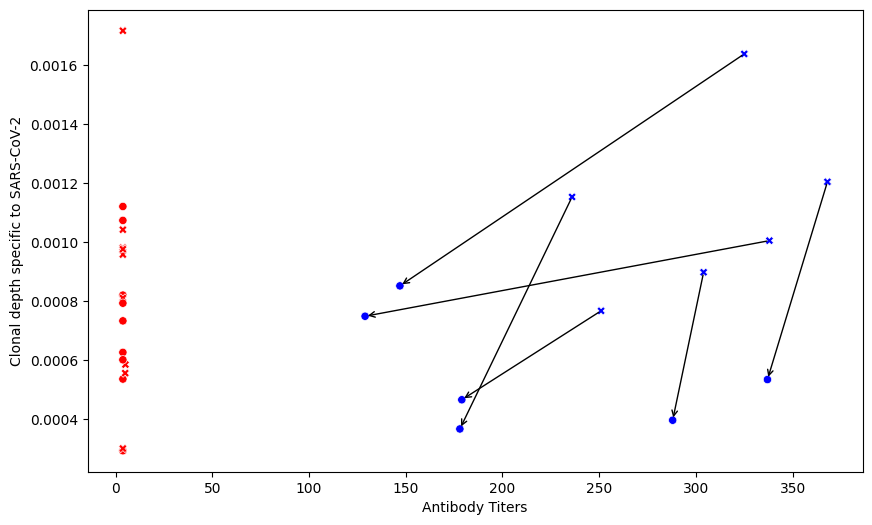

In [46]:
sns.scatterplot(pd.merge(clonal_depth_data, metadata, how='inner').query('TIMEPOINTS != "baseline"'),
                x='AB_TITER', y='cloneFraction', hue='CONDITION', style='TIMEPOINTS',
                palette={'Lymphoma patients': 'red', 'Healthy controls': 'blue'})
# remove grid
plt.grid(False)
# change y axis title
plt.ylabel('Clonal depth specific to SARS-CoV-2')
plt.xlabel('Antibody Titers')

# link dots that have the same sample_id with an arrow
for sample in pd.merge(clonal_depth_data, metadata, how='inner').query('TIMEPOINTS != "baseline" and CONDITION == "Healthy controls"')['SAMPLE'].unique():
    sample_data = pd.merge(clonal_depth_data, metadata, how='inner').query('TIMEPOINTS != "baseline" and SAMPLE == @sample')
    
    # add arrow between the two points
    plt.annotate('', xy=(sample_data['AB_TITER'].values[0], sample_data['cloneFraction'].values[0]),
                 xytext=(sample_data['AB_TITER'].values[1], sample_data['cloneFraction'].values[1]),
                 arrowprops=dict(arrowstyle='->', color='black', lw=1))
    
# change dimensions
plt.gcf().set_size_inches(10, 6)

# hide legend
plt.legend().set_visible(False)
# save the plot at 600 dpi
plt.savefig(PLOTSDIR + 'clonal_depth_ab_titers.png', dpi=600, bbox_inches='tight')

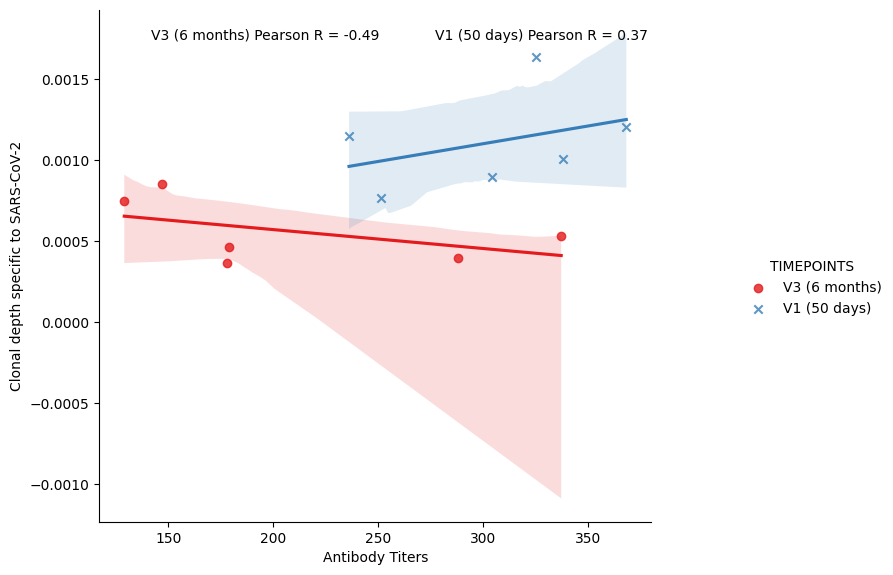

In [55]:
healthy_data = (pd.merge(clonal_depth_data, metadata, how='inner')
                .query('TIMEPOINTS != "baseline" and CONDITION == "Healthy controls"'))


sns.lmplot(x="AB_TITER", y="cloneFraction", hue="TIMEPOINTS", data=healthy_data, markers=["o", "x"], palette="Set1")
# change size of the plot
plt.gcf().set_size_inches(10, 6)
plt.ylabel('Clonal depth specific to SARS-CoV-2')
plt.xlabel('Antibody Titers')

# add R^2 value to the plot for each timepoint
for i,timepoint in enumerate(healthy_data['TIMEPOINTS'].unique()):
    timepoint_data = healthy_data.query('TIMEPOINTS == @timepoint')
    r, p = pearsonr(timepoint_data['AB_TITER'], timepoint_data['cloneFraction'])
    plt.text(0.3+i*0.5, .95, f'{timepoint} Pearson R = {r:.2f}', ha='center', va='center', transform=plt.gca().transAxes)
    
    # save the plot at 600 dpi
plt.savefig(PLOTSDIR + 'clonal_depth_ab_titers_correlation.png', dpi=600, bbox_inches='tight')

In [56]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
plot_clonal_depth = ro.globalenv['plot_clonal_depth']
plot_clonal_depth(clonal_depth_data[['cloneFraction', 'CONDITION', 'TIMEPOINTS', 'SAMPLE']], PLOTSDIR)

R[write to console]: In aggiunta: 
R[write to console]: Messaggi di avvertimento:

R[write to console]: 1: 
R[write to console]: In printCoefmat(x$coefficients, digits = digits, signif.stars = signif.stars) :
R[write to console]: 
 
R[write to console]:  NA introdotti per coercizione

R[write to console]: 2: Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 



Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Saving 7 x 7 in image


array(['/Users/fabioaffaticati/Desktop/Work/lymphoma_covid/results/plots/scatteratio_depth.png'],
      dtype='<U86')

In [57]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
linear_mixed_model = ro.globalenv['linear_mixed_model']
linear_mixed_model(clonal_depth_data[['cloneFraction', 'CONDITION', 'TIMEPOINTS', 'SAMPLE']], MODELSDIR)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: cloneFraction ~ CONDITION * TIMEPOINTS + (1 | SAMPLE)
   Data: df

REML criterion at convergence: -512,1

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1,64673 -0,50343 -0,06227  0,48475  2,74165 

Random effects:
 Groups   Name        Variance  Std.Dev. 
 SAMPLE   (Intercept) 3,649e-08 0,0001910
 Residual             6,058e-08 0,0002461
Number of obs: 45, groups:  SAMPLE, 15

Fixed effects:
                                                     Estimate Std. Error
(Intercept)                                         0,0007409  0,0001272
CONDITIONLymphoma patients                         -0,0001027  0,0001642
TIMEPOINTSV1 (50 days)                              0,0003696  0,0001421
TIMEPOINTSV3 (6 months)                            -0,0001810  0,0001421
CONDITIONLymphoma patients:TIMEPOINTSV1 (50 days)  -0,0001277  0,0001835
CONDITIONLymphoma patients:TIMEPOINTSV3 (6 months)  

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



Saving 10 x 7 in image


array(['/Users/fabioaffaticati/Desktop/Work/lymphoma_covid/results/models/lmm_model_depth_pwpp.png'],
      dtype='<U90')

## V Gene usage

In [164]:
combined_predictions_hla_test = combined_predictions.query('SAMPLE != "s_1" and SAMPLE != "s_10"').pivot(index='SAMPLE', columns='locus', values='match')
combined_predictions_hla_test['HLA_A'] = combined_predictions_hla_test['HLA-A'].str.split('*').str[1]
combined_predictions_hla_test['HLA_B'] = combined_predictions_hla_test['HLA-B'].str.split('*').str[1]
combined_predictions_hla_test['HLA_C'] = combined_predictions_hla_test['HLA-C'].str.split('*').str[1]
metadata_test = pd.merge(metadata, combined_predictions_hla_test, on='SAMPLE', how='left')
metadata_test = metadata_test[['sample_id', 'SAMPLE', 'CONDITION', 'TIMEPOINTS', 'HLA_A', 'HLA_B', 'HLA_C']].query('SAMPLE != "s_1" and SAMPLE != "s_10"')
metadata_test = pd.merge(metadata_test, clonal_breadth_data[['sample_id', 'fraction_sequences']], on='sample_id', how='left')

In [165]:
trbv_gene_usage = data.query('TCR_Chain == "TRB"').query('SAMPLE != "s_1" and SAMPLE != "s_10"')
#trbv_gene_usage = trbv_gene_usage[trbv_gene_usage['clonotype'].isin(DETECT_predictions['clonotype'])]
rows_to_remove = trbv_gene_usage.query('v_call == "TRBV15" and j_call == "TRBJ2-2" and junction_aa == "CATSLANTGELFF" and SAMPLE == "s_9"')
trbv_gene_usage = trbv_gene_usage[~trbv_gene_usage.isin(rows_to_remove)].dropna()
#trbv_gene_usage['Comparison_stat'] = trbv_gene_usage['CONDITION'] + ' ' + trbv_gene_usage['TIMEPOINTS']
trbv_gene_usage = trbv_gene_usage.pivot_table(index=['sample_id', 'CONDITION', 'TIMEPOINTS'], columns='v_call', values='cloneFraction', fill_value=0, aggfunc='sum')
trbv_gene_usage.head()


,,v_call,TRBV10-1,TRBV10-2,TRBV10-3,TRBV11-1,TRBV11-2,TRBV11-3,TRBV12-3,TRBV12-4,TRBV12-5,TRBV13,...,TRBV6-8,TRBV6-9,TRBV7-2,TRBV7-3,TRBV7-4,TRBV7-6,TRBV7-7,TRBV7-8,TRBV7-9,TRBV9
sample_id,CONDITION,TIMEPOINTS,,,,,,,,,,,,,,,,,,,,,
10L,Lymphomas,baseline,0.000055,0.000697,0.007444,0.001028,0.002926,0.000436,0.012703,0.009156,0.003129,0.002736,...,0.000093,0.000057,0.024979,0.007939,0.000113,0.003882,0.002392,0.010957,0.054070,0.010784
11L,Lymphomas,V1,0.000079,0.000641,0.007365,0.001242,0.004653,0.000688,0.012213,0.012238,0.002458,0.001786,...,0.000036,0.000061,0.023740,0.006822,0.000070,0.003859,0.002395,0.010276,0.039550,0.009571
12L,Lymphomas,V3,0.000044,0.000576,0.004777,0.000814,0.003490,0.000435,0.010326,0.012356,0.002957,0.001499,...,0.000014,0.000035,0.017002,0.004315,0.000056,0.002501,0.002175,0.008211,0.049547,0.007848
13L,Lymphomas,baseline,0.000603,0.001133,0.008295,0.001318,0.006708,0.000693,0.016078,0.014124,0.001525,0.001075,...,0.000062,0.000056,0.022545,0.007654,0.000106,0.003293,0.000833,0.009639,0.012253,0.005564
14L,Lymphomas,V1,0.000549,0.001312,0.006287,0.001136,0.008417,0.000793,0.020493,0.011951,0.001236,0.001376,...,0.000057,0.000050,0.021621,0.007672,0.000098,0.003155,0.000779,0.010697,0.016495,0.005718


In [166]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
correlation_heatmap = ro.globalenv['correlation_heatmap']
correlation_heatmap(pd.merge(trbv_gene_usage.reset_index(),
                             metadata_test[['sample_id', 'SAMPLE', 'HLA_A', 'HLA_B', 'HLA_C']],
                            on='sample_id', how='left'), PLOTSDIR)

R[write to console]: In aggiunta: 
R[write to console]: Messaggio di avvertimento:

R[write to console]: In printCoefmat(x$coefficients, digits = digits, signif.stars = signif.stars) :
R[write to console]: 
 
R[write to console]:  NA introdotti per coercizione



<rpy2.robjects.functions.SignatureTranslatedFunction object at 0x3507ae390> [7]
R classes: ('function',)

In [167]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
correlation_heatmap_pertime = ro.globalenv['correlation_heatmap_pertime']

for time in trbv_gene_usage.reset_index()['TIMEPOINTS'].unique():
    correlation_heatmap_pertime(pd.merge(trbv_gene_usage.reset_index().query('TIMEPOINTS == @time').drop(columns=['TIMEPOINTS']),
                            metadata_test[['sample_id', 'SAMPLE', 'HLA_A', 'HLA_B', 'HLA_C']],
                            on='sample_id', how='left'), time, PLOTSDIR)    

Cluster Analysis for Timepoint baseline:
Contingency Table for Cluster 1:
       
        Healthy Lymphomas
  FALSE       4         4
  TRUE        2         5
Contingency Table for Cluster 2:
       
        Healthy Lymphomas
  FALSE       3         7
  TRUE        3         2
Contingency Table for Cluster 3:
       
        Healthy Lymphomas
  FALSE       5         8
  TRUE        1         1
Contingency Table for Cluster 4:
       
        Healthy Lymphomas
  FALSE       6         8
  TRUE        0         1
[1] "P-Values from Fisher Tests:"
[1] 0,6083916 0,3286713 1,0000000 1,0000000
[1] "Adjusted P-Values:"
[1] 1 1 1 1
Cluster Analysis for Timepoint V1:
Contingency Table for Cluster 1:
       
        Healthy Lymphomas
  FALSE       3         6
  TRUE        3         3
Contingency Table for Cluster 2:
       
        Healthy Lymphomas
  FALSE       3         5
  TRUE        3         4
Contingency Table for Cluster 3:
       
        Healthy Lymphomas
  FALSE       6         8
  

### Covid specific V  gene usage

In [169]:
trbv_gene_usage = data.query('TCR_Chain == "TRB"').query('SAMPLE != "s_1" and SAMPLE != "s_10"')
trbv_gene_usage = trbv_gene_usage[trbv_gene_usage['clonotype'].isin(DETECT_predictions['clonotype'])]
rows_to_remove = trbv_gene_usage.query('v_call == "TRBV15" and j_call == "TRBJ2-2" and junction_aa == "CATSLANTGELFF" and SAMPLE == "s_9"')
trbv_gene_usage = trbv_gene_usage[~trbv_gene_usage.isin(rows_to_remove)].dropna()
#trbv_gene_usage['Comparison_stat'] = trbv_gene_usage['CONDITION'] + ' ' + trbv_gene_usage['TIMEPOINTS']
trbv_gene_usage = trbv_gene_usage.pivot_table(index=['sample_id', 'CONDITION', 'TIMEPOINTS'], columns='v_call', values='cloneFraction', fill_value=0, aggfunc='sum')
trbv_gene_usage.head()


,,v_call,TRBV10-1,TRBV10-2,TRBV10-3,TRBV11-1,TRBV11-2,TRBV11-3,TRBV12-3,TRBV12-4,TRBV12-5,TRBV13,...,TRBV6-5,TRBV6-6,TRBV7-2,TRBV7-3,TRBV7-4,TRBV7-6,TRBV7-7,TRBV7-8,TRBV7-9,TRBV9
sample_id,CONDITION,TIMEPOINTS,,,,,,,,,,,,,,,,,,,,,
10L,Lymphomas,baseline,0.000000,0.000000e+00,6.372051e-06,0.0,0.000000,0.0,0.000002,0.0,0.000000,0.0,...,0.000000,0.000001,0.000015,0.000021,0.0,0.000000,0.000000,0.000003,0.000019,0.000000
11L,Lymphomas,V1,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,0.000009,0.0,0.000000,0.0,...,0.000000,0.000002,0.000008,0.000005,0.0,0.000000,0.000000,0.000006,0.000035,0.000000
12L,Lymphomas,V3,0.000000,0.000000e+00,8.630175e-07,0.0,0.000003,0.0,0.000016,0.0,0.000000,0.0,...,0.000001,0.000008,0.000020,0.000003,0.0,0.000001,0.000002,0.000005,0.000013,0.000010
13L,Lymphomas,baseline,0.000000,0.000000e+00,5.183970e-06,0.0,0.000000,0.0,0.000016,0.0,0.000000,0.0,...,0.000000,0.000013,0.000021,0.000023,0.0,0.000000,0.000000,0.000001,0.000024,0.000007
14L,Lymphomas,V1,0.000001,4.330129e-07,4.763142e-06,0.0,0.000001,0.0,0.000017,0.0,0.000002,0.0,...,0.000004,0.000005,0.000028,0.000027,0.0,0.000004,0.000003,0.000003,0.000038,0.000012


In [170]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
correlation_heatmap = ro.globalenv['correlation_heatmap']
correlation_heatmap(pd.merge(trbv_gene_usage.reset_index(),
                             metadata_test[['sample_id', 'SAMPLE', 'HLA_A', 'HLA_B', 'HLA_C']],
                            on='sample_id', how='left'), PLOTSDIR)

<rpy2.robjects.functions.SignatureTranslatedFunction object at 0x1077b9ed0> [7]
R classes: ('function',)

In [171]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
correlation_heatmap_pertime = ro.globalenv['correlation_heatmap_pertime']

for time in trbv_gene_usage.reset_index()['TIMEPOINTS'].unique():
    correlation_heatmap_pertime(pd.merge(trbv_gene_usage.reset_index().query('TIMEPOINTS == @time').drop(columns=['TIMEPOINTS']),
                            metadata_test[['sample_id', 'SAMPLE', 'HLA_A', 'HLA_B', 'HLA_C']],
                            on='sample_id', how='left'), time, PLOTSDIR)

Cluster Analysis for Timepoint baseline:
Contingency Table for Cluster 1:
       
        Healthy Lymphomas
  FALSE       6         4
  TRUE        0         5
Contingency Table for Cluster 3:
       
        Healthy Lymphomas
  FALSE       5         7
  TRUE        1         2
Contingency Table for Cluster 4:
       
        Healthy Lymphomas
  FALSE       5         8
  TRUE        1         1
Contingency Table for Cluster 2:
       
        Healthy Lymphomas
  FALSE       2         8
  TRUE        4         1
[1] "P-Values from Fisher Tests:"
[1] 0,04395604 1,00000000 1,00000000 0,08891109
[1] "Adjusted P-Values:"
[1] 0,1758242 1,0000000 1,0000000 0,1778222
Cluster Analysis for Timepoint V1:
Contingency Table for Cluster 1:
       
        Healthy Lymphomas
  FALSE       6         7
  TRUE        0         2
Contingency Table for Cluster 2:
       
        Healthy Lymphomas
  FALSE       4         7
  TRUE        2         2
Contingency Table for Cluster 3:
       
        Healthy Ly

In [177]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
pca_biplot_vgenes = ro.globalenv['pca_biplot_vgenes']
pca_biplot_vgenes(trbv_gene_usage.reset_index(drop=True),
                  pd.merge(trbv_gene_usage.reset_index()[['sample_id', 'CONDITION', 'TIMEPOINTS']], 
                  metadata_test, on = ['sample_id', 'CONDITION', 'TIMEPOINTS'],
                  how='left')[['sample_id', 'CONDITION', 'TIMEPOINTS', 'SAMPLE', 'HLA_A', 'HLA_B', 'HLA_C', 'fraction_sequences']], PLOTSDIR)

R[write to console]: Caricamento del pacchetto richiesto: ggpubr

R[write to console]: 
Caricamento pacchetto: ‘ggpubr’


R[write to console]: Il seguente oggetto è mascherato da ‘package:cowplot’:

    get_legend


R[write to console]: Caricamento del pacchetto richiesto: limma

R[write to console]: Caricamento del pacchetto richiesto: BiocParallel

R[write to console]: 
Caricamento pacchetto: ‘variancePartition’


R[write to console]: Il seguente oggetto è mascherato da ‘package:limma’:

    topTable




[1] "Dimensions of variance_input:"
[1] 45 45
[1] "Dimensions of metadata:"
[1] 45  9
[1] "Metadata summary:"
  sample_id             CONDITION     TIMEPOINTS     SAMPLE       HLA_A   
 Length:45          Healthy  :18   baseline:15   s_11   : 3   02:01  :18  
 Class :character   Lymphomas:27   V1      :15   s_12   : 3   03:01  : 6  
 Mode  :character                  V3      :15   s_13   : 3   26:01  : 6  
                                                 s_14   : 3   01:01  : 3  
                                                 s_15   : 3   23:01  : 3  
                                                 s_16   : 3   (Other): 6  
                                                 (Other):27   NA's   : 3  
   HLA_B        HLA_C    fraction_sequences   CovidBreadth      
 07:02: 9   06:02  :12   Min.   :0,0007317   Min.   :0,0007317  
 14:02: 3   04:01  : 9   1st Qu.:0,0010515   1st Qu.:0,0010515  
 18:01: 9   07:02  : 9   Median :0,0011214   Median :0,0011214  
 35:01:15   01:02  : 3   Mean 

R[write to console]: Avvertimento:
R[write to console]:  
Variables contain NA's: HLA_A 
Samples with missing data will be dropped.




[1] "Variance partitioning results:"
   CONDITION            HLA_A             HLA_B             HLA_C         
 Min.   :0,000000   Min.   :0,00000   Min.   :0,00000   Min.   :0,000000  
 1st Qu.:0,000000   1st Qu.:0,00000   1st Qu.:0,00000   1st Qu.:0,000000  
 Median :0,000000   Median :0,00000   Median :0,00000   Median :0,000000  
 Mean   :0,001571   Mean   :0,03935   Mean   :0,02018   Mean   :0,006017  
 3rd Qu.:0,000000   3rd Qu.:0,00000   3rd Qu.:0,00000   3rd Qu.:0,000000  
 Max.   :0,035783   Max.   :0,66553   Max.   :0,35533   Max.   :0,136796  
     SAMPLE          TIMEPOINTS       Residuals     
 Min.   :0,00000   Min.   :0,0000   Min.   :0,3345  
 1st Qu.:0,00000   1st Qu.:0,0000   1st Qu.:0,8592  
 Median :0,00000   Median :0,0000   Median :0,9406  
 Mean   :0,04663   Mean   :0,0146   Mean   :0,8717  
 3rd Qu.:0,01196   3rd Qu.:0,0000   3rd Qu.:1,0000  
 Max.   :0,45423   Max.   :0,1993   Max.   :1,0000  
[1] "Sorted variance partitioning results:"
            HLA_C    CO

2


In [ ]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')


pca_biplot_vgenes_pertime = ro.globalenv['pca_biplot_vgenes_pertime']

for time in trbv_gene_usage.reset_index()['TIMEPOINTS'].unique():
    trbv_time = trbv_gene_usage.reset_index().query('TIMEPOINTS == @time').drop(columns=['TIMEPOINTS'])
    trbv_time.set_index(['sample_id', 'CONDITION'], inplace=True)
    pca_biplot_vgenes_pertime(trbv_time,
                              pd.merge(trbv_time.reset_index()[['sample_id', 'CONDITION']],
                              metadata_test, on = ['sample_id', 'CONDITION'],
                              how = 'left')[['sample_id', 'CONDITION', 'SAMPLE', 'HLA_A', 'HLA_B', 'HLA_C', 'fraction_sequences']], time, PLOTSDIR)

[1] "Dimensions of variance_input:"
[1] 15 42
[1] "Dimensions of metadata:"
[1] 15  8
[1] "Metadata summary:"
  sample_id             CONDITION     SAMPLE      HLA_A     HLA_B       HLA_C  
 Length:15          Healthy  :6   s_11   :1   02:01  :6   07:02:3   06:02  :4  
 Class :character   Lymphomas:9   s_12   :1   03:01  :2   14:02:1   04:01  :3  
 Mode  :character                 s_13   :1   26:01  :2   18:01:3   07:02  :3  
                                  s_14   :1   01:01  :1   35:01:5   01:02  :1  
                                  s_15   :1   23:01  :1   39:01:1   05:01  :1  
                                  s_16   :1   (Other):2   44:02:2   07:01  :1  
                                  (Other):9   NA's   :1             (Other):2  
 fraction_sequences   CovidBreadth      
 Min.   :0,0007317   Min.   :0,0007317  
 1st Qu.:0,0009803   1st Qu.:0,0009803  
 Median :0,0010512   Median :0,0010512  
 Mean   :0,0010662   Mean   :0,0010662  
 3rd Qu.:0,0011829   3rd Qu.:0,0011829  
 Max

R[write to console]: Avvertimento:
R[write to console]:  
Variables contain NA's: HLA_A 
Samples with missing data will be dropped.




[1] "Variance partitioning results:"
   CONDITION           HLA_A            HLA_B            HLA_C        
 Min.   :0,00000   Min.   :0,0000   Min.   :0,0000   Min.   :0,00000  
 1st Qu.:0,00000   1st Qu.:0,0000   1st Qu.:0,0000   1st Qu.:0,00000  
 Median :0,00000   Median :0,0950   Median :0,0000   Median :0,00000  
 Mean   :0,03786   Mean   :0,1510   Mean   :0,1068   Mean   :0,14363  
 3rd Qu.:0,02172   3rd Qu.:0,2155   3rd Qu.:0,1641   3rd Qu.:0,08482  
 Max.   :0,21720   Max.   :0,6736   Max.   :0,6261   Max.   :0,73428  
   Residuals       
 Min.   :0,001146  
 1st Qu.:0,178702  
 Median :0,616467  
 Mean   :0,560694  
 3rd Qu.:0,966910  
 Max.   :1,000000  
[1] "Sorted variance partitioning results:"
            HLA_A        HLA_B        HLA_C    CONDITION   Residuals
PC1  0,000000e+00 0,000000e+00 0,000000e+00 0,000000e+00 1,000000000
PC2  1,833608e-01 1,963470e-01 8,963621e-12 3,366207e-12 0,620292214
PC3  2,215137e-01 0,000000e+00 2,875783e-12 1,658444e-01 0,612641831
PC4  1

R[write to console]: Avvertimento:
R[write to console]:  
Variables contain NA's: HLA_A 
Samples with missing data will be dropped.




[1] "Variance partitioning results:"
   CONDITION             HLA_A            HLA_B            HLA_C         
 Min.   :0,0000000   Min.   :0,0000   Min.   :0,0000   Min.   :0,000000  
 1st Qu.:0,0000000   1st Qu.:0,0000   1st Qu.:0,0000   1st Qu.:0,000000  
 Median :0,0000000   Median :0,1273   Median :0,0000   Median :0,005489  
 Mean   :0,0380804   Mean   :0,2042   Mean   :0,1384   Mean   :0,130996  
 3rd Qu.:0,0004543   3rd Qu.:0,4059   3rd Qu.:0,2339   3rd Qu.:0,092382  
 Max.   :0,4619440   Max.   :0,5303   Max.   :0,5966   Max.   :0,744757  
   Residuals        
 Min.   :0,0000946  
 1st Qu.:0,0541421  
 Median :0,4171759  
 Mean   :0,4883309  
 3rd Qu.:0,9065003  
 Max.   :1,0000000  
[1] "Sorted variance partitioning results:"
            HLA_A        HLA_C        HLA_B    CONDITION    Residuals
PC1  2,545427e-01 7,447571e-01 0,000000e+00 6,056966e-04 9,458304e-05
PC2  2,792758e-01 9,136504e-02 5,965667e-01 0,000000e+00 3,279251e-02
PC3  6,938605e-10 0,000000e+00 1,089657e-01 

R[write to console]: Avvertimento:
R[write to console]:  
Variables contain NA's: HLA_A 
Samples with missing data will be dropped.




[1] "Variance partitioning results:"
   CONDITION            HLA_A              HLA_B             HLA_C          
 Min.   :0,000000   Min.   :0,000000   Min.   :0,00000   Min.   :0,0000000  
 1st Qu.:0,000000   1st Qu.:0,000000   1st Qu.:0,00000   1st Qu.:0,0000000  
 Median :0,000000   Median :0,005075   Median :0,02245   Median :0,0009473  
 Mean   :0,035328   Mean   :0,124647   Mean   :0,20873   Mean   :0,1420591  
 3rd Qu.:0,003641   3rd Qu.:0,189589   3rd Qu.:0,26197   3rd Qu.:0,1045986  
 Max.   :0,221101   Max.   :0,720671   Max.   :0,97455   Max.   :0,7428134  
   Residuals       
 Min.   :0,000005  
 1st Qu.:0,088299  
 Median :0,483643  
 Mean   :0,489238  
 3rd Qu.:0,855990  
 Max.   :1,000000  
[1] "Sorted variance partitioning results:"
          HLA_B      HLA_A        HLA_C    CONDITION    Residuals
PC1  0,81664472 0,09997308 0,000000e+00 6,169226e-02 2,168993e-02
PC2  0,97455020 0,01014902 1,894503e-03 0,000000e+00 1,340628e-02
PC3  0,00000000 0,00000000 0,000000e+00 0,

: 

### Test specific V gene usage of those samples that cluster together

In [67]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
test_cluster_vgenes = ro.globalenv['test_cluster_vgenes']
test_cluster_vgenes(trbv_gene_usage.reset_index(), metadata_test,
                    ['s_11', 's_12', 's_13', 's_14', 's_16'],
                    'baseline', '1', PLOTSDIR)

R[write to console]: 
Caricamento pacchetto: ‘reshape2’


R[write to console]: Il seguente oggetto è mascherato da ‘package:tidyr’:

    smiths




array(['/Users/fabioaffaticati/Desktop/Work/lymphoma_covid/results/plots/Vgene_spec_cluster1.png'],
      dtype='<U88')

In [68]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
test_cluster_vgenes = ro.globalenv['test_cluster_vgenes']
test_cluster_vgenes(trbv_gene_usage.reset_index(), metadata_test,
                    ['s_2', 's_3', 's_4', 's_7', 's_8'],
                    'baseline', '2', PLOTSDIR)

array(['/Users/fabioaffaticati/Desktop/Work/lymphoma_covid/results/plots/Vgene_spec_cluster2.png'],
      dtype='<U88')

In [69]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
test_cluster_vgenes = ro.globalenv['test_cluster_vgenes']
test_cluster_vgenes(trbv_gene_usage.reset_index(), metadata_test,
                    ['s_8', 's_9', 's_12', 's_16'],
                    'V3', '3', PLOTSDIR)

array(['/Users/fabioaffaticati/Desktop/Work/lymphoma_covid/results/plots/Vgene_spec_cluster3.png'],
      dtype='<U88')

In [70]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
test_cluster_vgenes = ro.globalenv['test_cluster_vgenes']
test_cluster_vgenes(trbv_gene_usage.reset_index(), metadata_test,
                    ['s_11', 's_13', 's_15', 's_17'],
                    'V3', '4', PLOTSDIR)

array(['/Users/fabioaffaticati/Desktop/Work/lymphoma_covid/results/plots/Vgene_spec_cluster4.png'],
      dtype='<U88')

In [71]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
test_cluster_vgenes = ro.globalenv['test_cluster_vgenes']
test_cluster_vgenes(trbv_gene_usage.reset_index(), metadata_test,
                    ['s_2', 's_4', 's_5', 's_7', 's_14'],
                    'V3', '5', PLOTSDIR)

array(['/Users/fabioaffaticati/Desktop/Work/lymphoma_covid/results/plots/Vgene_spec_cluster5.png'],
      dtype='<U88')